### Data Privacy Note
Please note, all the images used on this project are available on Google. I have used these images with positive intent just for the sake of opensource work.

In [5]:
import os
os.chdir('/content/drive/MyDrive/projects_assignment/aadhar_card_retrival_od')
os.getcwd()

'/content/drive/MyDrive/projects_assignment/aadhar_card_retrival_od'

In [6]:
os.getcwd()

'/content/drive/My Drive/projects_assignment/aadhar_card_retrival_od'

### Installing detetctron2 and Preparating other dependenices <br>
You just dont woeey about these packages and all. Just copy paste it

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 22kB/s 
     |████████████████████████████████| 6.6MB 40.6MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101


  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7hbf80jb
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-7hbf80jb
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263916 sha256=517fddff85d37fc7fa2a3015f3c53daf1cc69d9900017a1f942eeffb116182a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-06ptd11t/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools


In [1]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

s
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 768kB/s 
  Found existing installation: detectron2 0.3+cu101
    Uninstalling detectron2-0.3+cu101:
      Successfully uninstalled detectron2-0.3+cu101


In [5]:
#  After installation, you need to "restart runtime" in Colab.
#  Below line can also restart runtime
#exit(0)

In [2]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



### Data Annotation
I used Roboflow for data annotation and downloaded in coco format. Refer the link below for more details.<br>
https://app.roboflow.com/

### Register dataset with detectron2 to register
So now we'll have to add dataset to detectron register that it internally maintains

In [9]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/projects_assignment/aadhar_card_retrival_od/_annotations.coco.json",
                        "/content/drive/MyDrive/projects_assignment/aadhar_card_retrival_od/train")

### Visualize a train sample
You should always look at your trainig data before training model. It's a good practice to not screw up.

In [13]:
dataset_dicts[1]

{'annotations': [{'bbox': [239, 124, 65, 25],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6,
   'iscrowd': 0},
  {'bbox': [161, 138, 75, 24],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 3,
   'iscrowd': 0},
  {'bbox': [199, 163, 42, 22],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 5,
   'iscrowd': 0},
  {'bbox': [136, 284, 149, 42],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 1,
   'iscrowd': 0}],
 'file_name': '/content/drive/MyDrive/projects_assignment/aadhar_card_retrival_od/train/086d820550f34066764f4047ddc263ca_jpg.rf.092a4002cdf8bb62a9d07eff42a4b66b.jpg',
 'height': 416,
 'image_id': 1,
 'width': 416}

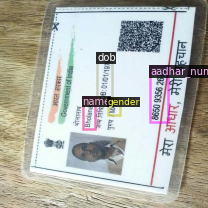

In [22]:
d = dataset_dicts[101]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(d)
cv2_imshow(vis.get_image()[:, :, ::-1])

### Writing model configuration and Training model on custom data
Writing the model configuration and loading weights from detectron2 model_zoo. For more detail please always refer official documentation.

In [25]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator

#initializing the default config 
cfg = get_cfg()

# We'll merge the model baseline config to the initial config
# Add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library

# We're trying fatser RCNN OD baseline by getting config file from "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
# You could try other models. Ref - https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = () #later it will fix the error. Even if no test set, better mention empty one


# Loading weights for the same model. 
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
# you can play with other batch size. Since dataset is small so I kept just 5 sample per batch size
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
############# Be careful here. Always make sure this class numbers are right
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7 #your number of classes + 1



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/20 13:11:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.


[03/20 13:11:56 d2.engine.train_loop]: Starting training from iteration 0
[03/20 13:13:57 d2.utils.events]:  eta: 1:37:21  iter: 19  total_loss: 3.356  loss_cls: 1.886  loss_box_reg: 0.226  loss_rpn_cls: 1.162  loss_rpn_loc: 0.077  time: 5.9073  data_time: 0.1056  lr: 0.000020  max_mem: 9105M
[03/20 13:15:56 d2.utils.events]:  eta: 1:39:06  iter: 39  total_loss: 2.709  loss_cls: 1.491  loss_box_reg: 0.695  loss_rpn_cls: 0.483  loss_rpn_loc: 0.050  time: 5.9355  data_time: 0.0323  lr: 0.000040  max_mem: 9105M
[03/20 13:17:55 d2.utils.events]:  eta: 1:30:39  iter: 59  total_loss: 2.225  loss_cls: 1.129  loss_box_reg: 0.817  loss_rpn_cls: 0.181  loss_rpn_loc: 0.065  time: 5.9368  data_time: 0.0333  lr: 0.000060  max_mem: 9105M
[03/20 13:19:54 d2.utils.events]:  eta: 1:28:43  iter: 79  total_loss: 1.947  loss_cls: 0.965  loss_box_reg: 0.847  loss_rpn_cls: 0.076  loss_rpn_loc: 0.046  time: 5.9437  data_time: 0.0312  lr: 0.000080  max_mem: 9105M
[03/20 13:21:53 d2.utils.events]:  eta: 1:26:4

FileNotFoundError: ignored

In [27]:
cfg.OUTPUT_DIR

'./output'

### Looking at Trained model
We'll see how well our model is trained. 

In [ ]:
d = dataset_dicts[101]
img = cv2.imread('/content/drive/MyDrive/projects_assignment/aadhar_card_retrival_od/train/25305fe9d4d92e3899f5fbcab86fb2c7--1-_jpg.rf.da42905b0ffe62d8ee4d6b640018c63a.jpg')
visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(d)
cv2_imshow(vis.get_image()[:, :, ::-1])

In [26]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [76]:
outputs.get('instances')

Instances(num_instances=4, image_height=416, image_width=416, fields=[pred_boxes: Boxes(tensor([[104.0314, 239.5506, 279.2333, 271.6540],
        [ 99.7174, 171.1478, 168.8796, 187.8246],
        [161.7861, 177.0926, 277.8241, 194.7710],
        [130.6519, 193.1747, 166.9418, 208.4460]], device='cuda:0')), scores: tensor([0.9953, 0.9922, 0.9856, 0.9814], device='cuda:0'), pred_classes: tensor([1, 6, 3, 5], device='cuda:0')])

Labels for the object detection

In [94]:
class_labels = train_metadata.thing_classes
class_labels

['name', 'aadhar_number', 'address', 'dob', 'father', 'gender', 'name']

### Prediction method
This method basically does the object detetction, then crop the objects out of images

In [255]:
def show_result(path, class_labels):
  #get the image from the path
  im = cv2.imread(path)

  #get the predictions from the model
  outputs = predictor(im)

  #get all the predicted class
  isinstance_output = outputs.get('instances')

  print('Predicted objects - - - - \n')
  for object_ in range(len(isinstance_output)):
    try:
      print(class_labels[int(isinstance_output[object_].get('pred_classes'))], round(float(isinstance_output[object_].get('scores'))*100, 2), '%')
      # for obj in range(len(isinstance_output)):
      x = int(list(isinstance_output[object_].get_fields().get('pred_boxes'))[0][0])
      y = int(list(isinstance_output[object_].get_fields().get('pred_boxes'))[0][1])

      #get the width and height
      w = int(list(isinstance_output[object_].get_fields().get('pred_boxes'))[0][2])
      h = int(list(isinstance_output[object_].get_fields().get('pred_boxes'))[0][3])

      #get the actual heihgt and width
      actaul_w = w - x
      actual_h = h - y

      crop_img = im[y:y+actual_h, x:x+actaul_w]
      cv2_imshow(crop_img[:, :, ::-1])

      print('\n')
    except:
      continue

  # Display the image
  v = Visualizer(im[:, :, ::-1],metadata=train_metadata, scale=0.8)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

Predicted objects - - - - 

aadhar_number 99.53 %


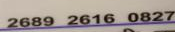



name 99.22 %




dob 98.56 %




gender 98.14 %


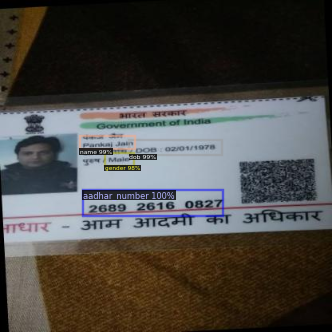

In [256]:
show_result(os.getcwd()+'/train/49fa3bcf36cda2851f2d12adc5f9f6db_png.rf.059f9d083214eff162e17183184efe74.jpg', class_labels)

Predicted objects - - - - 

aadhar_number 99.47 %


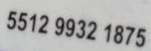



gender 98.94 %




name 98.59 %


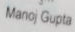



dob 91.71 %


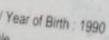

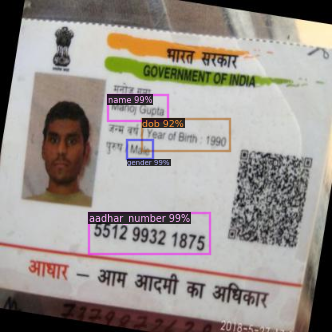

In [258]:
show_result(os.getcwd()+'/train/25305fe9d4d92e3899f5fbcab86fb2c7--1-_jpg.rf.67b6217d811650d7ac1bcf47cb7025e5.jpg', class_labels)

Predicted objects - - - - 

aadhar_number 99.78 %


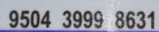



gender 99.45 %




name 97.48 %




dob 95.44 %




father 83.25 %




address 44.64 %


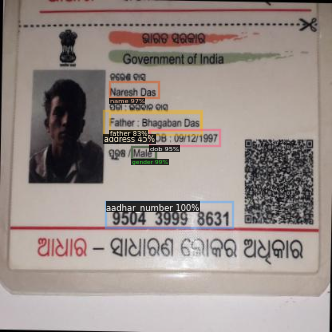

In [259]:
show_result(os.getcwd()+'/train/4c45f3182c0db2c0019216fd330c6ca7_jpg.rf.14089900c50fa6dea000c068bca7b36f.jpg', class_labels)

#### Conclusion of from above
As we can see it's working fairly good.

### Extracting text from Objects
Now the main game, getting text from the objects and cleaning it up. <br>
For this we'll use Tesseract. Basically we'll perform OCR on the object and later good to go.

Installing Tesseract

In [260]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,692 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [261]:
import pytesseract
from PIL import Image
import pandas as pd
import pickle

In [273]:
outputs = predictor(im)

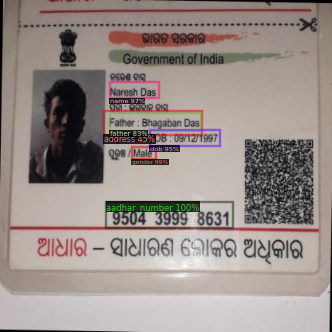


Predicted objects - - - - 

aadhar_number 99.78 %


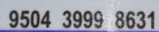


OCR Text :  9504 3999 8631
 


gender 99.45 %



OCR Text :   


name 97.48 %



OCR Text :  Naresh Das
 


dob 95.44 %



OCR Text :  08 ; 09/12/1997
 


father 83.25 %



OCR Text :  Father  Bhagaban Das
 


address 44.64 %



OCR Text :   
 




In [280]:
# Display the image
v = Visualizer(im[:, :, ::-1],metadata=train_metadata, scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])


#get all the predicted class
isinstance_output = outputs.get('instances')

print('\nPredicted objects - - - - \n')
for object_ in range(len(isinstance_output)):
  try:
    print(class_labels[int(isinstance_output[object_].get('pred_classes'))], round(float(isinstance_output[object_].get('scores'))*100, 2), '%')
    # for obj in range(len(isinstance_output)):
    x = int(list(isinstance_output[object_].get_fields().get('pred_boxes'))[0][0])
    y = int(list(isinstance_output[object_].get_fields().get('pred_boxes'))[0][1])

    #get the width and height
    w = int(list(isinstance_output[object_].get_fields().get('pred_boxes'))[0][2])
    h = int(list(isinstance_output[object_].get_fields().get('pred_boxes'))[0][3])

    #get the actual heihgt and width
    actaul_w = w - x
    actual_h = h - y

    crop_img = im[y:y+actual_h, x:x+actaul_w]
    cv2_imshow(crop_img[:, :, ::-1])

    # now show the image to text
    # here I'm using PIL package to get an Image from the array - It took a while to figureout this 
    object_text = pytesseract.image_to_string(Image.fromarray(crop_img))
    print('\nOCR Text : ', object_text, '\n\n')
  except:
    continue

### Final Conclusion
So it's working okayish. Ofcourse the purpose of this project was to have a baseline code which can be later tuned with more data and training. <br>
Next step would be making an API services around this. We'll see how this goes.